# 4 FMSSVRC
__Fashion-MNIST Small Scale Visual Recognition Challenge__

We want to write a powerful model that can make accurate predictions and correctly classify different pieces of clothing.

Most of the code is already written, including a deep neural network model.
However, the performance of said model is subpar. It is your task to complete indicated functions and cells, so that you can train the model. Further, you should change and tweak the model as well as hyperparameters to create a well performing model. You can aim for accuracies in the high 80ies!

Experiment around with architecture choices and different hyperparamters. The lecture slides and PyTorch give you a good overview of what is possible. Keep in mind, though, that blindly copy-pasting code from other sources without proper referencing and consent can be seen as plagiarism.

The quality of your model is evaluated on the test data set. Continously optimising your model according to the performance on the test data set is bad scientific practice. Ideally, the evaluation on the test data should happen  just once, when you are confident that you have trained your model to the best of your knowledge. While tweaking your model, you may evaluate its quality on a validation set of the data.

You are not allowed to change arbitrary code of the notebook. Instead, functions, variables etc. which you can change, will be indicated explicitely (see __Task__ keyword).
Please leave the seeds intact!

## 4.1 Installing PyTorch

In [1]:
!pip install torch torchvision

Defaulting to user installation because normal site-packages is not writeable


In [2]:
import torch
import torch.nn as nn
import torchvision
torch.manual_seed(42)
import matplotlib.pyplot as plt
import numpy as np

## 4.2 Obtaining the dataset
We are going to use the [Fashion-MNIST](https://arxiv.org/abs/1708.07747) dataset, which is a more difficult alternative to the standard MNIST dataset.

In [3]:
# if, for some reason, you are not using a UNIX-based operating system, \
# you might need to adjust the path arguments
trainset = torchvision.datasets.FashionMNIST(root='./data', train=True,
                                        download=True, transform=torchvision.transforms.ToTensor())
testset = torchvision.datasets.FashionMNIST(root='./data', train=False,
                                       download=True, transform=torchvision.transforms.ToTensor())
label_names = {0:"T-shirt/top", 1:"Trouser", 2:"Pullover", 3:"Dress",
               4:"Coat", 5:"Sandal", 6:"Shirt", 7:"Sneaker", 8:"Bag", 
               9:"Ankle boot"}

### Task 4.2.1 Inspecting a sample from the data
Choose a random sample from the training data, and:
- print its shape
- visualise the sample with an appropriate plot
- print its label (or title the plot appropriately)

torch.Size([28, 28])


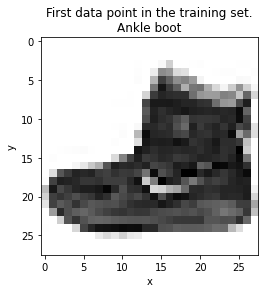

In [4]:
print(trainset[0][0][0].size())

plt.imshow(trainset[0][0][0], cmap="Greys")
plt.title("First data point in the training set.\n" + label_names[trainset[0][1]])
plt.xlabel("x")
plt.ylabel("y")
plt.show()


### Task 4.2.2 Validation Split 

__YOU MAY EDIT PARTS OF THE NEXT CELL__

In order to judge the quality of your training efforts, you might want to validate your model on a part of the data it has not seen yet. However, we cannot do that repeatedly on the test data set.

Therefore, we can split off some data from our training data. Make a decision about the validation split! The more data you take off from the training set, the more accurate will your evaluation be. The less data you leave for actual training, the worse your model performance will be.

_Hint:_ Currently, the validation size is 100, which seems a bit small.

In [5]:
validation_size = 100 # set the size of your validation set
trainset, valset = torch.utils.data.random_split(trainset, 
                                                 [len(trainset)-validation_size, validation_size], 
                                                 generator=torch.Generator().manual_seed(1337))

### 4.2.3 Torch DataLoader
Now we can hand over our three datasets to the DataLoader class which brings a lot of convience to the training procedure. It can batch and shuffle our data.

The batch size is set to 32 which is an appropriate value. You may change the batch_size for the trainloader, if you want.

Shuffling is not needed for validation and testing because we are only running through the data once, anyway.

In [6]:
trainloader = torch.utils.data.DataLoader(trainset, batch_size=32,
                                          shuffle=True)

testloader = torch.utils.data.DataLoader(testset, batch_size=32,
                                         shuffle=False)

valloader = torch.utils.data.DataLoader(valset, batch_size=32,
                                         shuffle=False)

## Task 4.3 Building a Model with torch.nn.Sequential
__YOU MAY EDIT PARTS OF THE NEXT CELL__

We are going to use [torch.nn.Sequential](https://pytorch.org/docs/stable/generated/torch.nn.Sequential.html) to build a multi-layer perceptron (not a CNN!).
You can simply supply [layers and building blocks](https://pytorch.org/docs/stable/nn.html) as arguments to create your network architecture in a sequential way, i.e. the data will flow through the network in the order they are listed as arguments.

Useful modules for MLPs are:
- [Linear Layers](https://pytorch.org/docs/stable/generated/torch.nn.Linear.html#torch.nn.Linear)
- [Activation Functions](https://pytorch.org/docs/stable/nn.html#non-linear-activations-weighted-sum-nonlinearity)
- [Dropout Layers](https://pytorch.org/docs/stable/nn.html#dropout-layers)

The input to the model is an image, which has to be flattened to a vector, so that it is represented as suitable input for the MLP.

The output must be a vector of size 10 (according to our labels/classes).

You are supplied with a model that does not perform too well. You are free to build a MLP of your choosing. Be aware, that larger networks will take more time to train!

Tips for experimentation:
- Layer sizes
- Number of layers
- Activation functions
- Dropout

_Hint:_ What is known in PyTorch as a linear layer refers to a fully connected or dense layer.

In [7]:
model = nn.Sequential(nn.Flatten(),
                      nn.Linear(28*28, 20),
                      nn.Sigmoid(),
                      nn.Linear(20, 10),
                      nn.Sigmoid()
                      )

## 4.4 Training the model
Now that we have a model architecture, we will need to specify a training procedure.

### Task 4.4.1 Choosing hyperparameters
__YOU MAY EDIT PARTS OF THE NEXT CELL__

A few parameters for the training process need to be predefined and are not learned via gradient descent or backprop. We refere to these as hyperparameters.

In the following, you are presented with four of those that shape the training process and can have great influence on the trained models performance.

The machine-learning practictioner who set up this notebook apparently did not pay full attention to the lecture and literature. Although all lead to a working model, the values of some are not chosen to the best of our knowledge.

In [14]:
learning_rate = 0.1
loss = nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr=learning_rate)
epochs = 200

### 4.4.2 The train function
This function trains your model for one epoch and keeps track of the correct/incorrect predictions.

It takes a model, a dataloader, and optimizer and a loss function, trains the model for one epoch and returns the mean loss over the epoch as well as the accuracy.

In [9]:
def train(model, dataloader, optimizer, loss):
    epoch_loss = []
    model.train()
    correct = 0
    total = 0
    for img, lbl in dataloader:
        optimizer.zero_grad() 
        out = model(img) 
        logits, indices = torch.max(out, 1)
        correct += torch.sum(indices == lbl).item()
        total += len(lbl)
        batch_loss = loss(out, lbl) 
        batch_loss.backward() 
        optimizer.step() 
        epoch_loss.append(batch_loss.item()) 
    return np.mean(epoch_loss), correct/total

### 4.4.3 The validation function
This function evaluations your model on specified data.

It takes a model and a dataloader and returns the accuracy.

In [10]:
def evaluate(model, dataloader):
    model.eval()
    correct = 0
    total = 0
    for img, lbl in dataloader:
        out = model(img)
        logits, indices = torch.max(out, 1)
        correct += torch.sum(indices == lbl).item()
        total += len(lbl)
    return correct/total

### Task 4.4.4 The training loop
Write the training loop for your model:
- Call the train function for your model for the specified number of epochs. 
- For each epoch, keep track of the loss and the training accuracy.
- You should also keep track of the validation accuracy, to judge the models actual performance on unseen data.
- Store all values for visualisation purposes later on.

Run your training loop! Depending on the size of your network architecture and the number of epochs, this might take a few minutes.

In [15]:
accuracy = []
losses = []
for iter in range(epochs):
    l, a = train(model, trainloader, optimizer, loss)
    losses.append(l)
    accuracy.append(a)

### Task 4.4.5 Visualise the training
Visually inspecting the models behaviour over the training period can give insights on problems and performance issues.

Plot:
- the training loss and the training accuracy
- the validation accuracy

over the epochs.

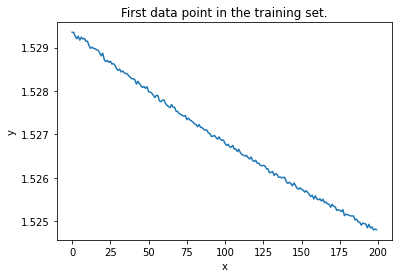

In [16]:
plt.plot(range(epochs), losses)
plt.title("First data point in the training set.")
plt.xlabel("x")
plt.ylabel("y")
plt.show()

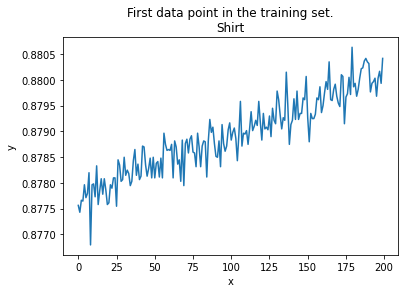

In [17]:
plt.plot(range(epochs), accuracy)
plt.title("First data point in the training set.\n" + label_names[trainset[0][1]])
plt.xlabel("x")
plt.ylabel("y")
plt.show()

## 4.5 Testing your model
The following should only be executed once. If you are not satisfied with your model performance, go back a few steps and tune your model with different parameters or change the model architecture.

If you are checking your model's performance on the test set and then tune it for better performance, you are essentially fitting your model to the test set. Your actual generalization capabilities will decrease.

In [18]:
test_acc = evaluate(model, testloader)
print("Your model correctly classified", round(test_acc*100,2), 
      "% of all samples.")

Your model correctly classified 85.09 % of all samples.


### Task 4.5.1 Prediction capabilities of the model
Although we now know the average prediction performance of the model on unseen data, not all data is as equally distributed as our training data. Some classes can be harder to predict, than others.

Analyse your models performance on the different classes and plot the prediction accuracies on the test set over the 10 classes.

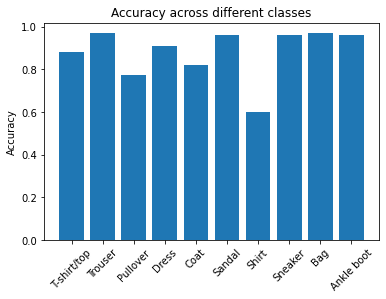

In [46]:
acc = [0] * 10
totals = [0] * 10
for img, lbl in trainset:
    out = model(img)
    _, indices = torch.max(out, 1)
    if indices == lbl:
        acc[lbl] += 1
    totals[lbl] += 1

for ite in range(10):
    acc[ite] /= totals[ite]

plt.bar(label_names.values(), acc)
plt.title("Accuracy across different classes")
plt.ylabel("Accuracy")
plt.xticks(rotation=45)
plt.show()